In [1]:
import numpy as np
from hyperopt import hp, fmin, tpe, space_eval
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from explicit_functions import dual_control, upstream_repression, no_control, downstream_activation, loss_biological

In [2]:
da = pd.read_csv('da_background.csv')
da['circuit'] = 'Downstream Activation'
ur = pd.read_csv('ur_background.csv')
ur['circuit'] = 'Upstream Repression'
nc = pd.read_csv('nc_background.csv')
nc['circuit'] = 'No Control'
dc = pd.read_csv('dc_background.csv')
dc['circuit'] = 'Dual Control'


perturbed_dc = pd.read_csv('dc_perturbation_grid.csv')
perturbed_dc['circuit'] = 'Dual Control'
perturbed_da = pd.read_csv('da_perturbation_grid.csv')
perturbed_da['circuit'] = 'Downstream Activation'
perturbed_nc = pd.read_csv('nc_perturbation_grid.csv')
perturbed_nc['circuit'] = 'No Control'
perturbed_ur = pd.read_csv('ur_perturbation_grid.csv')
perturbed_ur['circuit'] = 'Upstream Repression'

perturbed_dc1 = pd.read_csv('dc_perturbation_grid_1s.csv')
perturbed_dc1['circuit'] = 'Dual Control'
perturbed_da1 = pd.read_csv('da_perturbation_grid_1s.csv')
perturbed_da1['circuit'] = 'Downstream Activation'
perturbed_nc1 = pd.read_csv('nc_perturbation_grid_1s.csv')
perturbed_nc1['circuit'] = 'No Control'
perturbed_ur1 = pd.read_csv('ur_perturbation_grid_1s.csv')
perturbed_ur1['circuit'] = 'Upstream Repression'

perturbed = pd.concat([perturbed_dc, perturbed_da, perturbed_nc, perturbed_ur, perturbed_dc1, perturbed_da1, perturbed_nc1, perturbed_ur1])
perturbed['perturbed'] = True
background = pd.concat([da, ur, nc, dc])
background['perturbed'] = False
combined = pd.concat([perturbed, background])
combined = combined.loc[combined.num_iters > 150]
combined['km_perturb'] = combined.km_perturb.fillna(1)
combined['kc_perturb'] = combined.kc_perturb.fillna(1)

#combined.to_csv('perturb_viz_data_with_background.csv')

In [3]:
perturbed_dc10 = pd.read_csv('dc_10kperturbs.csv')
perturbed_dc10['circuit'] = 'Dual Control'
perturbed_dc10['perturbed'] = True

In [4]:
combined_dc = pd.concat([dc, perturbed_dc10])

In [5]:

features = ['k1', 'k2', 'theta1', 'theta2']

x = combined_dc.loc[:, features].values

#Normalize features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
combined_dc['pc1'] = principalComponents[:,0]
combined_dc['pc2'] = principalComponents[:,1]


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='pca')
tsne_results = tsne.fit_transform(x)
combined_dc['tsne1'] = tsne_results[:,0]
combined_dc['tsne2'] = tsne_results[:,1]

C:\Users\Charlotte\anaconda3\envs\sundials\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6661 samples in 0.007s...
[t-SNE] Computed neighbors for 6661 samples in 0.329s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6661
[t-SNE] Computed conditional probabilities for sample 2000 / 6661
[t-SNE] Computed conditional probabilities for sample 3000 / 6661
[t-SNE] Computed conditional probabilities for sample 4000 / 6661
[t-SNE] Computed conditional probabilities for sample 5000 / 6661
[t-SNE] Computed conditional probabilities for sample 6000 / 6661
[t-SNE] Computed conditional probabilities for sample 6661 / 6661
[t-SNE] Mean sigma: 0.233737


C:\Users\Charlotte\anaconda3\envs\sundials\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.748070
[t-SNE] KL divergence after 300 iterations: 2.182963


In [12]:
background = combined_dc.loc[combined_dc.perturbed != True]
perturbed = combined_dc.loc[combined_dc.perturbed == True]

Text(0, 0.5, 'Principal Component 2')

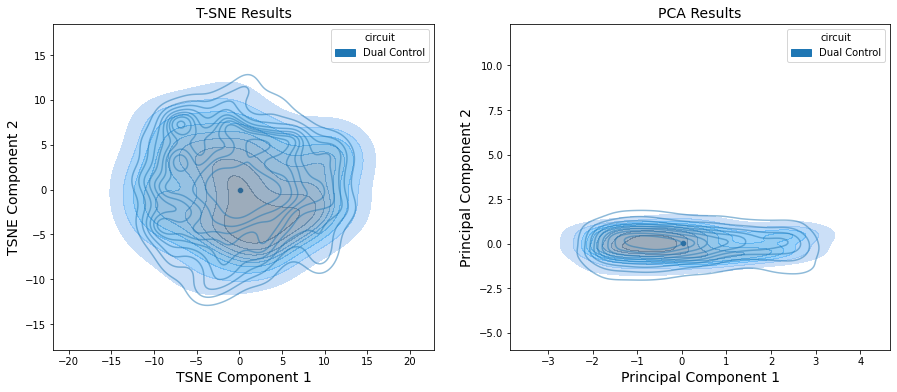

In [15]:
#Compute mean background losses by circuit type
means = background.groupby('circuit').mean()
alpha = 1
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

endpoint = 'T-SNE Results'
ax = axs[0]
#sns.scatterplot(x='pc1', y='pc2', data = finalDf, hue='loss', ax=ax)
sns.scatterplot(x="tsne1", y="tsne2", data=means, hue='circuit', alpha=alpha, ax=ax)
sns.kdeplot(
    data=perturbed,
    x="tsne1",
    y="tsne2",
    hue="circuit",
    thresh=.1, ax=ax, alpha=0.5
)

sns.kdeplot(
    data=background,
    x="tsne1",
    y="tsne2",
    hue="circuit",
    thresh=.1, ax=ax, alpha=0.5, fill=True
)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)


endpoint = 'PCA Results'
ax = axs[1]
sns.scatterplot(x="pc1", y="pc2", data=means, hue='circuit', alpha=alpha, ax=ax)
sns.kdeplot(
    data=perturbed,
    x="pc1",
    y="pc2",
    hue="circuit",
    thresh=.1, ax=ax, alpha=0.5
)

sns.kdeplot(
    data=background,
    x="pc1",
    y="pc2",
    hue="circuit",
    thresh=.1, ax=ax, alpha=0.5, fill=True
)

ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
#fig.savefig('TSNE_PCA_100background_GSperturbations.png')

Text(0, 0.5, 'TSNE Component 2')

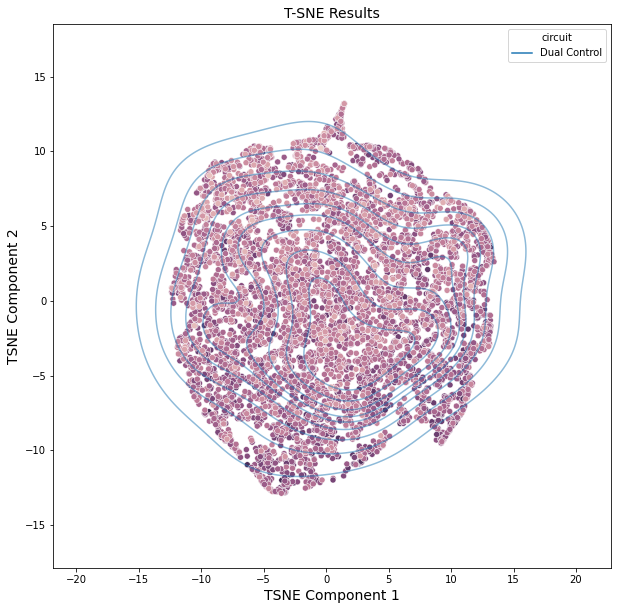

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

endpoint = 'T-SNE Results'
ax = axs
#sns.scatterplot(x='pc1', y='pc2', data = finalDf, hue='loss', ax=ax)
sns.scatterplot(x="tsne1", y="tsne2", data=perturbed, hue='normalized_perturbs', alpha=alpha, ax=ax)
sns.kdeplot(
    data=background,
    x="tsne1",
    y="tsne2",
    hue="circuit",
    thresh=.1, ax=ax, alpha=0.5
)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('TSNE Component 1', fontsize=14)
ax.set_ylabel('TSNE Component 2', fontsize=14)